In [2]:
import numpy as np
import scipy
import scipy.fftpack as fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
from scipy.signal import get_window
from scipy.io import wavfile

In [3]:
filepath = 'SpeechEmotion/happy/happy-0102.wav'
ipd.Audio(filepath)

In [4]:
srw, audio = wavfile.read(filepath)
y, srl = librosa.load(filepath, sr = 16000)
print('sr:', srw)
print('duration:', len(audio)/srw)

print('sr2:', srl)
print('duration2:', len(y)/srl)

print(audio)
print(y)

sr: 16000
duration: 2.1688125
sr2: 16000
duration2: 2.1688125
[-423 -428 -403 ...   -4   -4   -5]
[-0.01290894 -0.01306152 -0.01229858 ... -0.00012207 -0.00012207
 -0.00015259]


In [5]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

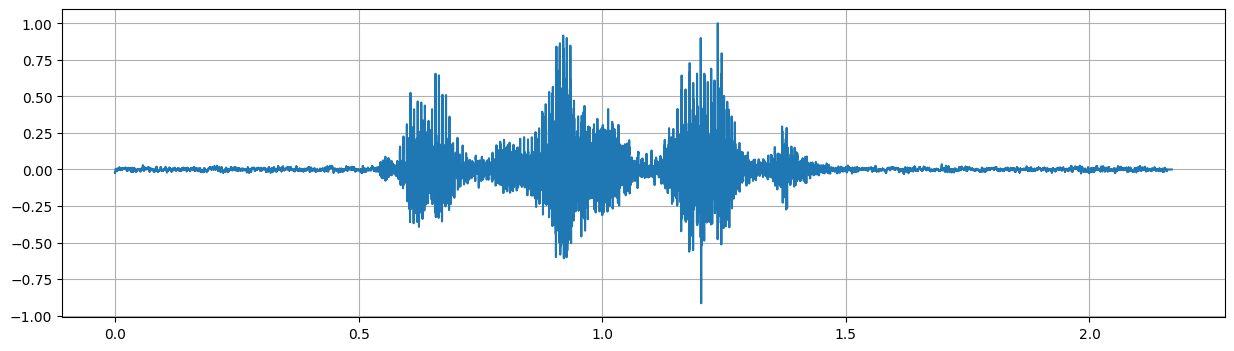

In [6]:
audiow = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audiow)/srw, num = len(audiow)), audiow)
plt.grid(True)

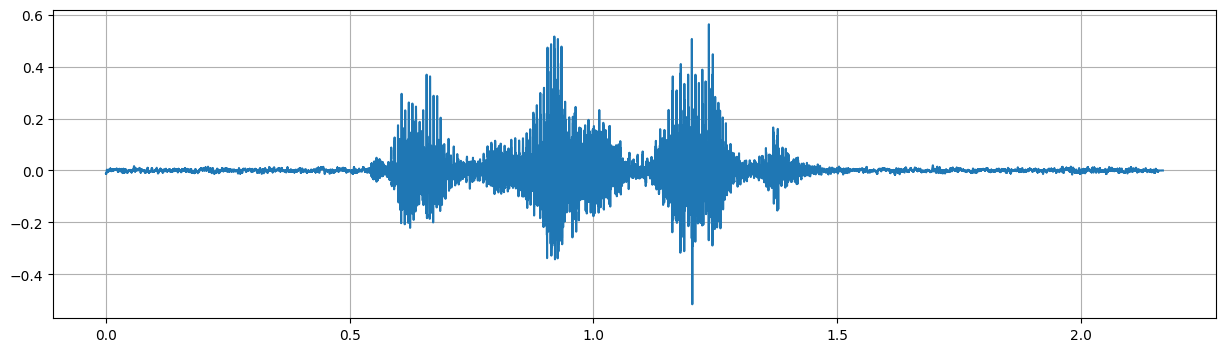

In [7]:
audiol = y
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audiol)/srl, num = len(audiol)), audiol)
plt.grid(True)

In [8]:
def frame_audio(audio, fft_size = 2048, hop_size = 10, sample_rate = 16000):
    audio = np.pad(audio, fft_size // 2, mode = 'reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - fft_size) / frame_len) + 1
    frames = np.zeros((frame_num, fft_size))

    for n in range(frame_num):
        frames[n] = audio[n * frame_len : n * frame_len + fft_size]
    
    return frames

In [9]:
hop_size = 15
fft_size = 2048

audiow_framed = frame_audio(audiow, fft_size = fft_size, hop_size = hop_size, sample_rate = srw)
print('framed audio shape: {0}'.format(audiow_framed.shape))

framed audio shape: (145, 2048)


In [10]:
hop_size = 15
fft_size = 2048

audiol_framed = frame_audio(audiol, fft_size = fft_size, hop_size = hop_size, sample_rate = srl)
print('framed audio shape: {0}'.format(audiol_framed.shape))

framed audio shape: (145, 2048)


In [11]:
print('first frame:')
print(audiow_framed[1])

print('last frame:')
print(audiow_framed[-1])

first frame:
[ 0.00211348  0.00233024  0.00243863 ... -0.00569013 -0.00617786
 -0.00623205]
last frame:
[-0.0203219  -0.02086382 -0.01929226 ...  0.01679944  0.0176665
  0.01782908]


In [12]:
print('first frame:')
print(audiol_framed[1])

print('last frame:')
print(audiol_framed[-1])

first frame:
[ 0.00119019  0.00131226  0.00137329 ... -0.00320435 -0.003479
 -0.00350952]
last frame:
[-0.01144409 -0.01174927 -0.01086426 ...  0.00946045  0.00994873
  0.01004028]


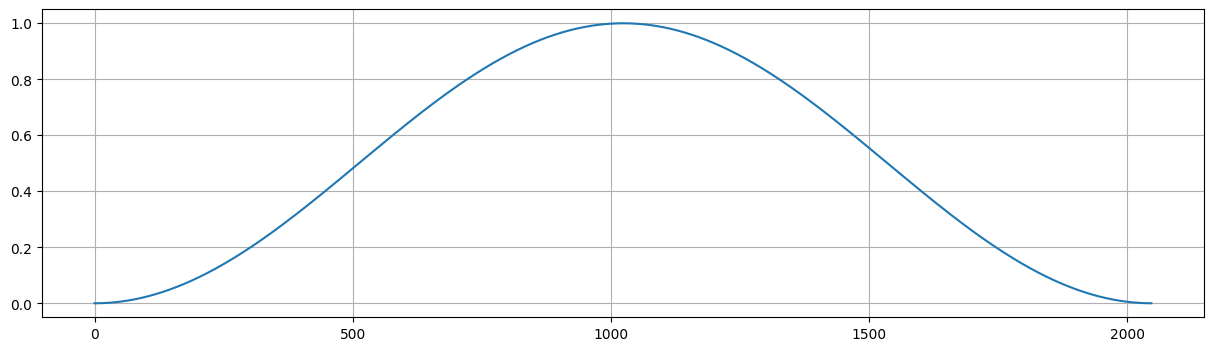

In [13]:
window = get_window('hann', fft_size, fftbins=True)
plt.figure(figsize=(15, 4))
plt.plot(window)
plt.grid(True)

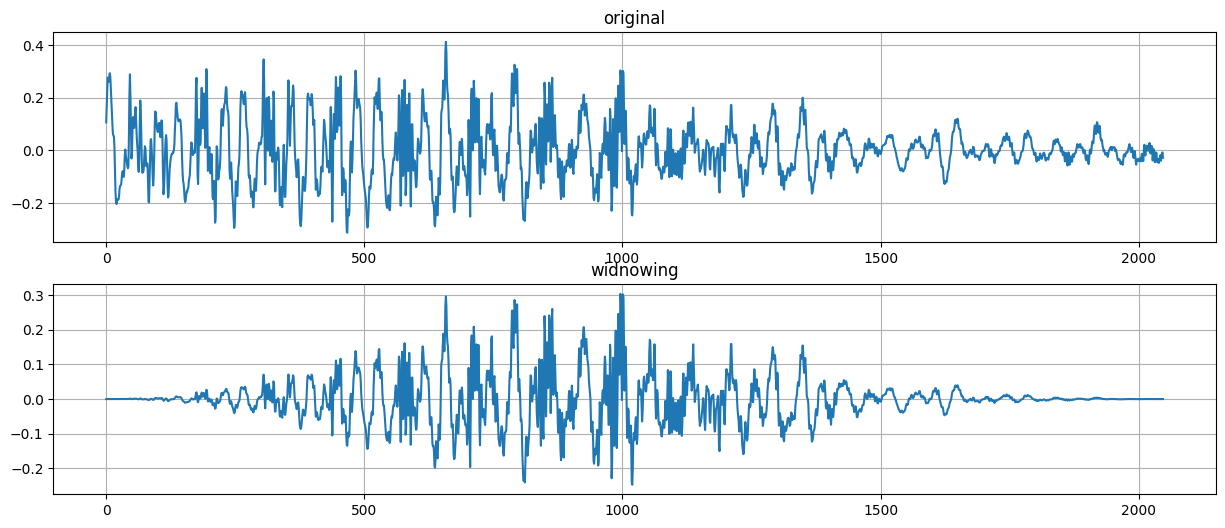

In [43]:
audiow_win = audiow_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audiow_framed[ind])
plt.title('original')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(audiow_win[ind])
plt.title('widnowing')
plt.grid(True)

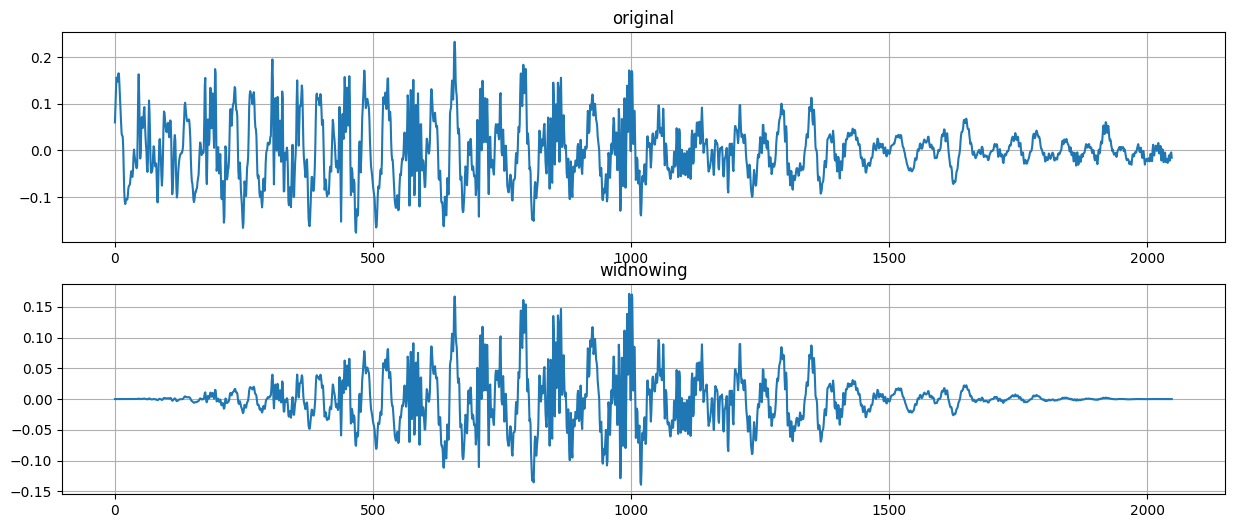

In [15]:
audiol_win = audiol_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audiol_framed[ind])
plt.title('original')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(audiol_win[ind])
plt.title('widnowing')
plt.grid(True)

In [45]:
audiow_wint = np.transpose(audiow_win)

audiow_fft = np.empty((int(1 + fft_size // 2), audiow_wint.shape[1]), dtype=np.complex64, order = 'F')

for n in range(audiow_fft.shape[1]):
    audiow_fft[:, n] = fft.fft(audiow_wint[:, n], axis=0)[:audiow_fft.shape[0]]

audiow_fft = np.transpose(audiow_fft)

In [46]:
audiol_wint = np.transpose(audiol_win)

audiol_fft = np.empty((int(1 + fft_size // 2), audiol_wint.shape[1]), dtype=np.complex64, order = 'F')

for n in range(audiol_fft.shape[1]):
    audiol_fft[:, n] = fft.fft(audiol_wint[:, n], axis=0)[:audiol_fft.shape[0]]

audiol_fft = np.transpose(audiol_fft)

In [48]:
audiow_power = np.square(np.abs(audiow_fft))
print(audiow_power.shape)

(145, 1025)


In [19]:
audiol_power = np.square(np.abs(audiol_fft))
print(audiol_power.shape)

(145, 1025)


In [20]:
freq_min = 0
freqw_high = srw / 2
freql_high = srl / 2
mel_filter_num = 10

print(freq_min)
print(freqw_high)
print(freql_high)

0
8000.0
8000.0


In [21]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [22]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=16000):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [23]:
filterw_points, melw_freqs = get_filter_points(freq_min, freqw_high, mel_filter_num, fft_size, sample_rate=16000)
filterw_points

MEL min: 0.0
MEL max: 2840.023046708319


array([   0,   23,   52,   88,  134,  192,  264,  355,  470,  614,  796,
       1024])

In [24]:
filterl_points, mell_freqs = get_filter_points(freq_min, freql_high, mel_filter_num, fft_size, sample_rate=16000)
filterl_points

MEL min: 0.0
MEL max: 2840.023046708319


array([   0,   23,   52,   88,  134,  192,  264,  355,  470,  614,  796,
       1024])

In [25]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

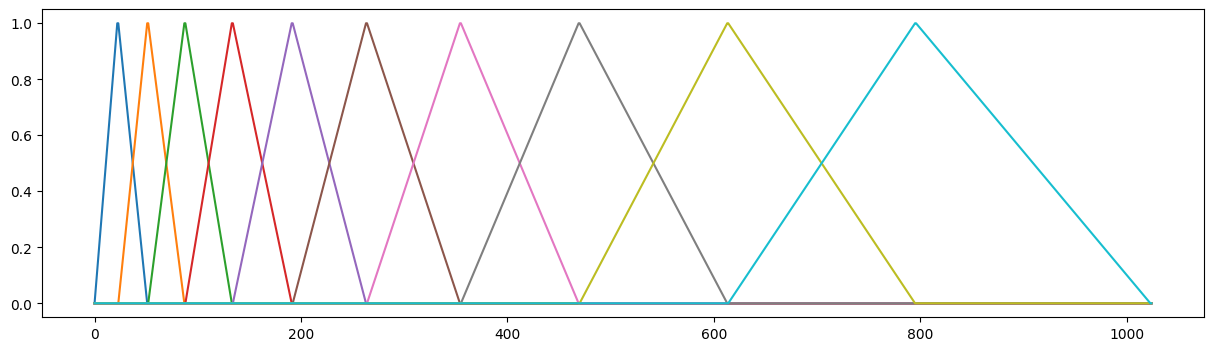

In [26]:
filtersw = get_filters(filterw_points, fft_size)

plt.figure(figsize=(15,4))
for n in range(filtersw.shape[0]):
    plt.plot(filtersw[n])

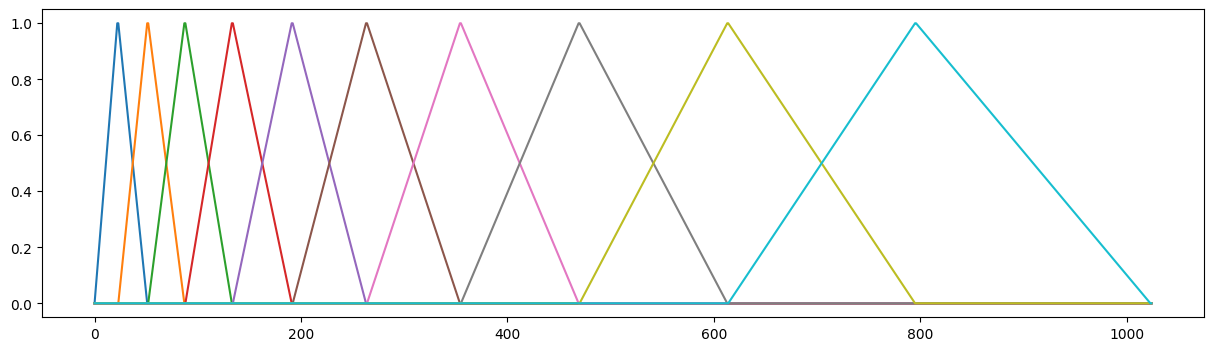

In [27]:
filtersl = get_filters(filterl_points, fft_size)

plt.figure(figsize=(15,4))
for n in range(filtersl.shape[0]):
    plt.plot(filtersl[n])

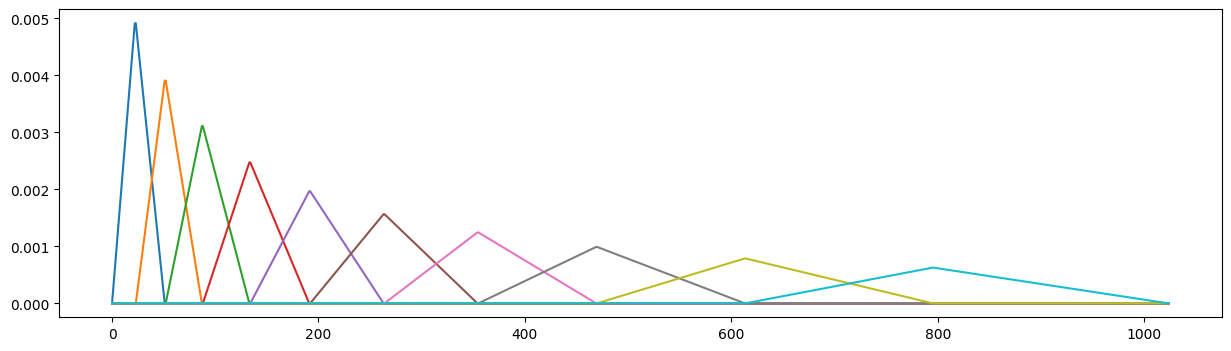

In [28]:
enorm = 2.0 / (melw_freqs[2 : mel_filter_num + 2] - melw_freqs[:mel_filter_num])
filtersw *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filtersw.shape[0]):
    plt.plot(filtersw[n])

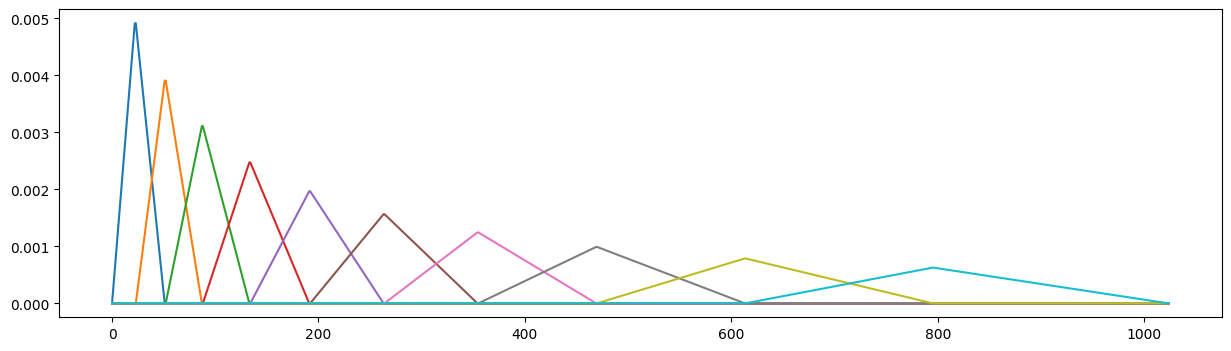

In [29]:
enorm = 2.0 / (mell_freqs[2 : mel_filter_num + 2] - mell_freqs[:mel_filter_num])
filtersl *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filtersl.shape[0]):
    plt.plot(filtersl[n])

In [30]:
audiow_filtered = np.dot(filtersw, np.transpose(audiow_power))
audiow_log = 10.0 * np.log10(audiow_filtered)
audiow_log.shape

(10, 145)

In [31]:
audiol_filtered = np.dot(filtersl, np.transpose(audiol_power))
audiol_log = 10.0 * np.log10(audiol_filtered)
audiol_log.shape

(10, 145)

In [32]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [33]:
dct_filter_num = 40
dctw_filters = dct(dct_filter_num, mel_filter_num)

cepstralw_coefficents = np.dot(dctw_filters, audiow_log)
cepstralw_coefficents.shape

(40, 145)

In [34]:
dctl_filters = dct(dct_filter_num, mel_filter_num)

cepstrall_coefficents = np.dot(dctl_filters, audiol_log)
cepstrall_coefficents.shape

(40, 145)

In [35]:
cepstralw_coefficents[:, 0]

array([-1.07223876e+02,  3.29025167e+01,  1.73621437e+01,  4.64244480e+00,
        2.57961997e+00,  4.27884071e-01, -1.10574813e+00,  2.20519481e-01,
       -5.07660517e-01, -8.17046713e-01,  1.81445143e-13,  8.17046713e-01,
        5.07660517e-01, -2.20519481e-01,  1.10574813e+00, -4.27884071e-01,
       -2.57961997e+00, -4.64244480e+00, -1.73621437e+01, -3.29025167e+01,
        1.51637459e+02, -3.29025167e+01, -1.73621437e+01, -4.64244480e+00,
       -2.57961997e+00, -4.27884071e-01,  1.10574813e+00, -2.20519481e-01,
        5.07660517e-01,  8.17046713e-01, -5.02788108e-14, -8.17046713e-01,
       -5.07660517e-01,  2.20519481e-01, -1.10574813e+00,  4.27884071e-01,
        2.57961997e+00,  4.64244480e+00,  1.73621437e+01,  3.29025167e+01])

In [36]:
cepstrall_coefficents[:, 0]

array([-1.22996239e+02,  3.29025168e+01,  1.73621437e+01,  4.64244482e+00,
        2.57961987e+00,  4.27884056e-01, -1.10574812e+00,  2.20519485e-01,
       -5.07660491e-01, -8.17046658e-01,  2.02622214e-13,  8.17046658e-01,
        5.07660491e-01, -2.20519485e-01,  1.10574812e+00, -4.27884056e-01,
       -2.57961987e+00, -4.64244482e+00, -1.73621437e+01, -3.29025168e+01,
        1.73942949e+02, -3.29025168e+01, -1.73621437e+01, -4.64244482e+00,
       -2.57961987e+00, -4.27884056e-01,  1.10574812e+00, -2.20519485e-01,
        5.07660491e-01,  8.17046658e-01, -5.43762632e-14, -8.17046658e-01,
       -5.07660491e-01,  2.20519485e-01, -1.10574812e+00,  4.27884056e-01,
        2.57961987e+00,  4.64244482e+00,  1.73621437e+01,  3.29025168e+01])

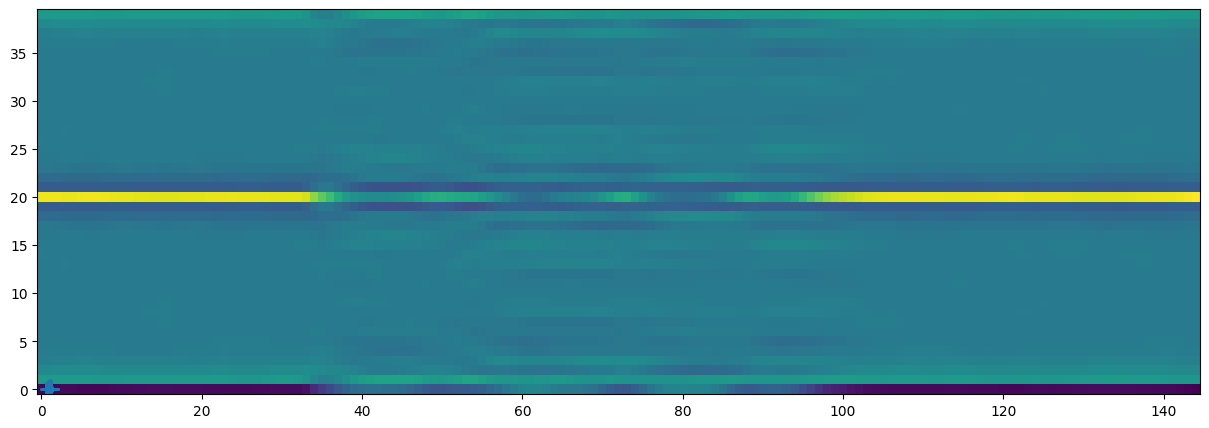

In [37]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audiow) / srw, num=len(audiow)), audiow)
plt.imshow(cepstralw_coefficents, aspect='auto', origin='lower');

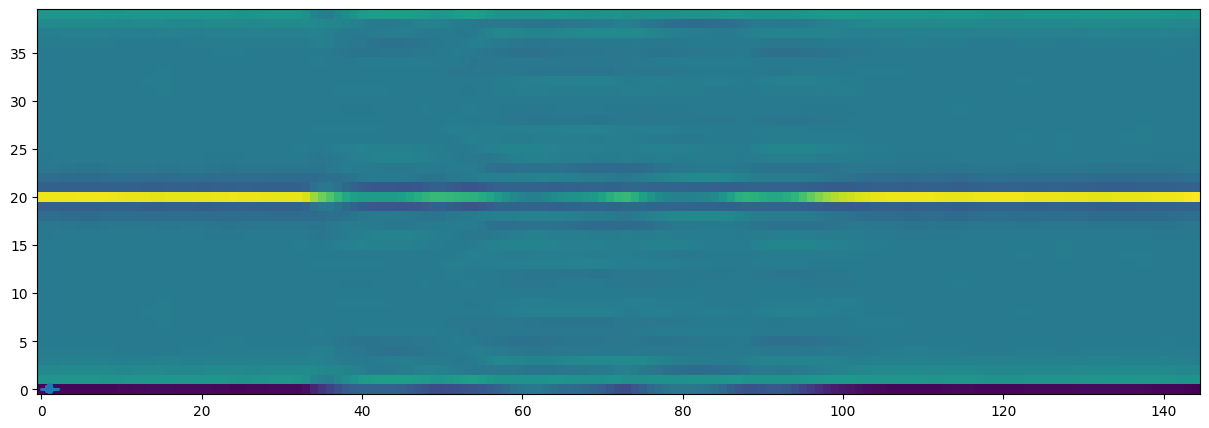

In [38]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audiol) / srl, num=len(audiol)), audiol)
plt.imshow(cepstrall_coefficents, aspect='auto', origin='lower');